In [1]:
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import mean_squared_error

from models import *
from autoencoder import *
from utils import *
from data import *

In [2]:
import os, pickle
import time
import random
import warnings
warnings.filterwarnings("ignore")

In [3]:
ts_configs = [
    ("Births",       Births,       30),
    ("Temperatures", Temperatures, 30),
]
autoencoder_embedding_flags = [False, True]
metrics_list = ["euclidean", "manhattan", "cosine"]
latent_dim = 2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda



Training AE on Births (window_size=30)
  Epoch 1/30 — loss: 0.651133
  Epoch 2/30 — loss: 0.328316
  Epoch 3/30 — loss: 0.282245
  Epoch 4/30 — loss: 0.189613
  Epoch 5/30 — loss: 0.161699
  Epoch 6/30 — loss: 0.138472
  Epoch 7/30 — loss: 0.122250
  Epoch 8/30 — loss: 0.113781
  Epoch 9/30 — loss: 0.109172
  Epoch 10/30 — loss: 0.105371
  Epoch 11/30 — loss: 0.102735
  Epoch 12/30 — loss: 0.100696
  Epoch 13/30 — loss: 0.098694
  Epoch 14/30 — loss: 0.096566
  Epoch 15/30 — loss: 0.094998
  Epoch 16/30 — loss: 0.093503
  Epoch 17/30 — loss: 0.091977
  Epoch 18/30 — loss: 0.090608
  Epoch 19/30 — loss: 0.089335
  Epoch 20/30 — loss: 0.087986
  Epoch 21/30 — loss: 0.086972
  Epoch 22/30 — loss: 0.086121
  Epoch 23/30 — loss: 0.084878
  Epoch 24/30 — loss: 0.083730
  Epoch 25/30 — loss: 0.083376
  Epoch 26/30 — loss: 0.082468
  Epoch 27/30 — loss: 0.081953
  Epoch 28/30 — loss: 0.080473
  Epoch 29/30 — loss: 0.080436
  Epoch 30/30 — loss: 0.079329
Saved AE: autoencoders\ae_Births.pth


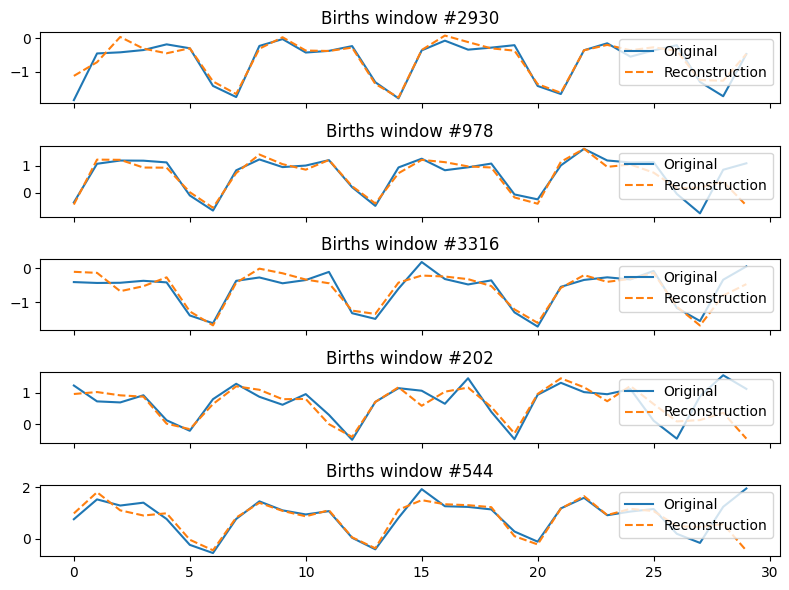


Training AE on Temperatures (window_size=30)
  Epoch 1/30 — loss: 1.023804
  Epoch 2/30 — loss: 0.640456
  Epoch 3/30 — loss: 0.453370
  Epoch 4/30 — loss: 0.360133
  Epoch 5/30 — loss: 0.337067
  Epoch 6/30 — loss: 0.310363
  Epoch 7/30 — loss: 0.261772
  Epoch 8/30 — loss: 0.234282
  Epoch 9/30 — loss: 0.213770
  Epoch 10/30 — loss: 0.203591
  Epoch 11/30 — loss: 0.196201
  Epoch 12/30 — loss: 0.188188
  Epoch 13/30 — loss: 0.182594
  Epoch 14/30 — loss: 0.182475
  Epoch 15/30 — loss: 0.175353
  Epoch 16/30 — loss: 0.175188
  Epoch 17/30 — loss: 0.171917
  Epoch 18/30 — loss: 0.169797
  Epoch 19/30 — loss: 0.165494
  Epoch 20/30 — loss: 0.166167
  Epoch 21/30 — loss: 0.164712
  Epoch 22/30 — loss: 0.163856
  Epoch 23/30 — loss: 0.162620
  Epoch 24/30 — loss: 0.162316
  Epoch 25/30 — loss: 0.161004
  Epoch 26/30 — loss: 0.159765
  Epoch 27/30 — loss: 0.156979
  Epoch 28/30 — loss: 0.162721
  Epoch 29/30 — loss: 0.161890
  Epoch 30/30 — loss: 0.159011
Saved AE: autoencoders\ae_Tempera

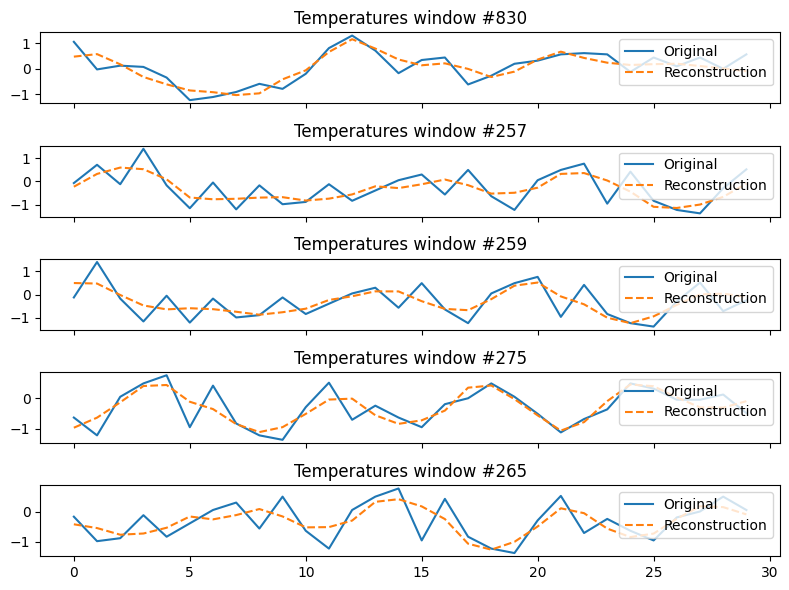

In [4]:
epochs = 30
lr     = 1e-3

for ds_name, DS, window_size in ts_configs:
    print(f"\nTraining AE on {ds_name} (window_size={window_size})")
    ts = DS(path=None, normalize=True)
    X_train, y_train, X_val, y_val, X_test, y_test = windowing(ts.data, window_size)
    
    
    # model + optimizer + loss
    ae        = ConvAutoencoder1D(window_size, latent_dim).to(device)
    optimizer = torch.optim.Adam(ae.parameters(), lr=lr)
    criterion = nn.MSELoss()
    
    # wrap as DataLoader of shape (batch, 1, window_size)
    ds_loader = DataLoader(
        TensorDataset(torch.tensor(X_train, dtype=torch.float).unsqueeze(1)),
        batch_size=64, shuffle=True
    )
    
    # training loop
    for epoch in range(1, epochs + 1):
        losses = []
        ae.train()
        for (batch_x,) in ds_loader:
            batch_x = batch_x.to(device)
            recon   = ae(batch_x)
            loss    = criterion(recon, batch_x)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        print(f"  Epoch {epoch}/{epochs} — loss: {np.mean(losses):.6f}")
    
    # save per‐dataset autoencoder
    ckpt_path = os.path.join("autoencoders", f"ae_{ds_name}.pth")
    torch.save(ae.state_dict(), ckpt_path)
    print(f"Saved AE: {ckpt_path}")

    # 6. Visualize reconstructions in eval mode
    ae.eval()
    sample_idxs = random.sample(range(len(X_train)), 5)
    fig, axes = plt.subplots(5, 1, figsize=(8, 6), sharex=True)
    for ax, idx in zip(axes, sample_idxs):
        orig = X_train[idx]
        with torch.no_grad():
            inp = torch.tensor(orig, dtype=torch.float).unsqueeze(0).unsqueeze(0).to(device)
            recon = ae(inp).cpu().squeeze().numpy()
        ax.plot(orig, label="Original")
        ax.plot(recon, linestyle="--", label="Reconstruction")
        ax.set_title(f"{ds_name} window #{idx}")
        ax.legend(loc="upper right")
    plt.tight_layout()
    plt.show()

In [5]:
for ds_name, DS, window_size in ts_configs:
    print(f"\n→ Dataset: {ds_name} (window_size={window_size})")
    ts = DS(path=None, normalize=True)
    X_train, y_train, X_val, y_val, X_test, y_test = windowing(ts.data, window_size)

    forecasters = {
    "ARIMA": ARIMAForecaster(),
    "ExpSmoothing": ExpSmoothingForecaster(),
    "LinearRegression": LinearRegressionForecaster(),
    "RandomForest": RandomForestForecaster(),
    "SVR": SVRForecaster(),
    "GradientBoosting": GradientBoostingForecaster(),
    "DT": DecisionTreeForecaster(),
    "MLP": MLPForecaster(),
    "LSTM": LSTMForecaster(window_size=window_size),
    "BiLSTM": BiLSTMForecaster(window_size=window_size),
    "CNNLSTM": CNNLSTMForecaster(window_size=window_size),
    }

    for name, model in forecasters.items():
        print(f"    → Training {name}…", end=" ")
        model.fit(X_train, y_train)

        # save the entire model object as a .pkl
        save_path = os.path.join("models", f"{ds_name}_{name}.pkl")
        with open(save_path, "wb") as f:
            pickle.dump(model, f)
        print(f"DONE: {save_path}")


→ Dataset: Births (window_size=30)
    → Training ARIMA… DONE: models\Births_ARIMA.pkl
    → Training ExpSmoothing… DONE: models\Births_ExpSmoothing.pkl
    → Training LinearRegression… DONE: models\Births_LinearRegression.pkl
    → Training RandomForest… DONE: models\Births_RandomForest.pkl
    → Training SVR… DONE: models\Births_SVR.pkl
    → Training GradientBoosting… DONE: models\Births_GradientBoosting.pkl
    → Training DT… DONE: models\Births_DT.pkl
    → Training MLP… DONE: models\Births_MLP.pkl
    → Training LSTM… 1/30 0.55077 | 15/30 0.06573 | 30/30 0.11280 | DONE: models\Births_LSTM.pkl
    → Training BiLSTM… 1/30 0.43911 | 15/30 0.08513 | 30/30 0.06426 | DONE: models\Births_BiLSTM.pkl
    → Training CNNLSTM… 1/30 0.22547 | 15/30 0.06374 | 30/30 0.05188 | DONE: models\Births_CNNLSTM.pkl

→ Dataset: Temperatures (window_size=30)
    → Training ARIMA… DONE: models\Temperatures_ARIMA.pkl
    → Training ExpSmoothing… DONE: models\Temperatures_ExpSmoothing.pkl
    → Training Li

In [6]:
MODELS_DIR = "models"
AE_DIR = "autoencoders"

loaded = {}
for ds_name, DS, window_size in ts_configs:
    print(f"\n→ Loading models for {ds_name} (window_size={window_size})")
    
    # 1) Load Autoencoder
    ae = ConvAutoencoder1D(window_size, latent_dim).eval().to(device)
    ae_ckpt = os.path.join(AE_DIR, f"ae_{ds_name}.pth")
    ae.load_state_dict(torch.load(ae_ckpt, map_location=device))
    print(f"     AE loaded from {ae_ckpt}")
    
    # 2) Load Forecasters
    forecasters = {}
    for name in [
        "ARIMA","ExpSmoothing","LinearRegression","RandomForest",
        "SVR","GradientBoosting","DT","MLP","LSTM","BiLSTM","CNNLSTM"
    ]:
        pkl_path = os.path.join(MODELS_DIR, f"{ds_name}_{name}.pkl")
        with open(pkl_path, "rb") as f:
            forecasters[name] = pickle.load(f)
        print(f"     {name} loaded from {pkl_path}")
    
    # store for later
    loaded[ds_name] = {
        "ae": ae,
        "forecasters": forecasters
    }


→ Loading models for Births (window_size=30)
     AE loaded from autoencoders\ae_Births.pth
     ARIMA loaded from models\Births_ARIMA.pkl
     ExpSmoothing loaded from models\Births_ExpSmoothing.pkl
     LinearRegression loaded from models\Births_LinearRegression.pkl
     RandomForest loaded from models\Births_RandomForest.pkl
     SVR loaded from models\Births_SVR.pkl
     GradientBoosting loaded from models\Births_GradientBoosting.pkl
     DT loaded from models\Births_DT.pkl
     MLP loaded from models\Births_MLP.pkl
     LSTM loaded from models\Births_LSTM.pkl
     BiLSTM loaded from models\Births_BiLSTM.pkl
     CNNLSTM loaded from models\Births_CNNLSTM.pkl

→ Loading models for Temperatures (window_size=30)
     AE loaded from autoencoders\ae_Temperatures.pth
     ARIMA loaded from models\Temperatures_ARIMA.pkl
     ExpSmoothing loaded from models\Temperatures_ExpSmoothing.pkl
     LinearRegression loaded from models\Temperatures_LinearRegression.pkl
     RandomForest loaded fro

In [7]:
for ds_name, DS, window_size in ts_configs:
    print(f"\n=== Validation RoC for {ds_name} (window_size={window_size}) ===")
    
    # Load data
    ts = DS(path=None, normalize=True)
    X_train, y_train, X_val, y_val, X_test, y_test = windowing(ts.data, window_size)

    # Load models
    ae          = loaded[ds_name]["ae"]
    forecasters = loaded[ds_name]["forecasters"]

    # Clear both RoCs
    for model in forecasters.values():
        model.rocs["raw"].clear()
        model.rocs["latent"].clear()

    # Iterate once over validation windows
    for idx, window in enumerate(X_val):
        # a) Pick winner based on raw input
        errors = {}
        for name, model in forecasters.items():
            y_pred = model.predict(window)
            errors[name] = mean_squared_error([y_val[idx]], [y_pred])
        winner = min(errors, key=errors.get)

        # b) Store both raw and latent versions
        raw_vec = window
        with torch.no_grad():
            latent_vec = ae.encode(window).cpu()

        forecasters[winner].rocs["raw"].append(raw_vec)
        forecasters[winner].rocs["latent"].append(latent_vec)

    # Report results
    print("RoC sizes")
    for name, model in forecasters.items():
        count = len(model.rocs["raw"])
        print(f"  {name:<18} {count:4d} entries")



=== Validation RoC for Births (window_size=30) ===
RoC sizes
  ARIMA               101 entries
  ExpSmoothing         52 entries
  LinearRegression    204 entries
  RandomForest        212 entries
  SVR                 171 entries
  GradientBoosting    209 entries
  DT                  175 entries
  MLP                 186 entries
  LSTM                176 entries
  BiLSTM              153 entries
  CNNLSTM             157 entries

=== Validation RoC for Temperatures (window_size=30) ===
RoC sizes
  ARIMA                92 entries
  ExpSmoothing         56 entries
  LinearRegression     55 entries
  RandomForest         97 entries
  SVR                  88 entries
  GradientBoosting     44 entries
  DT                  130 entries
  MLP                  64 entries
  LSTM                 62 entries
  BiLSTM               50 entries
  CNNLSTM             144 entries


In [8]:
def compute_distance(win1, win2, metric="euclidean"):
    """
    Compute distance between two windows using the specified metric.

    Parameters:
        win1, win2: numpy.ndarray or torch.Tensor of the same shape
        metric (str): one of "euclidean", "manhattan", or "cosine"

    Returns:
        float: the computed distance
    """
    if type(win1) != type(win2):
        raise TypeError(f"Both windows must be of the same type: first window is {type(win1)}")

    if win1.shape != win2.shape:
        raise ValueError(f"Shape mismatch: {win1.shape} vs {win2.shape}")

    # If numpy arrays
    if isinstance(win1, np.ndarray):
        if metric == "euclidean":
            return np.linalg.norm(win1 - win2)
        elif metric == "manhattan":
            return np.sum(np.abs(win1 - win2))
        elif metric == "cosine":
            num = np.dot(win1.flatten(), win2.flatten())
            denom = np.linalg.norm(win1) * np.linalg.norm(win2)
            return 1 - num / denom
        else:
            raise ValueError(f"Unsupported metric: {metric}")

    # If torch tensors
    elif isinstance(win1, torch.Tensor):
        if metric == "euclidean":
            return torch.norm(win1 - win2).item()
        elif metric == "manhattan":
            return torch.sum(torch.abs(win1 - win2)).item()
        elif metric == "cosine":
            return 1 - F.cosine_similarity(win1.flatten(), win2.flatten(), dim=0).item()
        else:
            raise ValueError(f"Unsupported metric: {metric}")

    else:
        raise TypeError("Unsupported input type. Use NumPy arrays or PyTorch tensors.")

In [9]:
print(f"Bottleneck size: {latent_dim}")
for ds_name, DS, window_size in ts_configs:
    print(f"\n=== Dataset: {ds_name} ===")
    # rebuild all splits
    X_train, y_train, X_val, y_val, X_test, y_test = windowing(ts.data, window_size)
    # ensure y_true is ndarray
    y_true = y_test if isinstance(y_test, np.ndarray) else y_test.cpu().numpy()

    ae = loaded[ds_name]["ae"]
    forecasters = loaded[ds_name]["forecasters"]

    for embed in autoencoder_embedding_flags:
        mode = "latent" if embed else "raw"
        for metric in metrics_list:

            t0 = time.perf_counter()

            preds = []
            for w in X_test:
                # 1) build query
                if embed:
                    with torch.no_grad():
                        q = ae.encode(w).cpu()            # q is a torch.Tensor
                else:
                    q = w                           # q is a np.ndarray

                # 2) nearest‐RoC lookup
                best_name, best_dist = None, float("inf")
                space = "latent" if embed else "raw"
                for name, model in forecasters.items():
                    for entry in model.rocs[space]:
                        if embed: entry.cpu()
                        d = compute_distance(q, entry, metric=metric)
                        if d < best_dist:
                            best_dist, best_name = d, name

                # 3) predict
                preds.append(forecasters[best_name].predict(w))

            # 4) compute & print MSE
            mse = mean_squared_error(y_true, preds)

            elapsed = time.perf_counter() - t0

            print(f"[{mode:^6}]  Metric={metric:<9}  Test MSE: {mse:.6f}  Time: {elapsed:.2f}s")

Bottleneck size: 2

=== Dataset: Births ===
[ raw  ]  Metric=euclidean  Test MSE: 0.529291  Time: 4.48s
[ raw  ]  Metric=manhattan  Test MSE: 0.499820  Time: 5.35s
[ raw  ]  Metric=cosine     Test MSE: 0.552653  Time: 8.24s
[latent]  Metric=euclidean  Test MSE: 0.537385  Time: 11.04s
[latent]  Metric=manhattan  Test MSE: 0.509905  Time: 11.29s
[latent]  Metric=cosine     Test MSE: 0.514223  Time: 24.84s

=== Dataset: Temperatures ===
[ raw  ]  Metric=euclidean  Test MSE: 0.428726  Time: 3.26s
[ raw  ]  Metric=manhattan  Test MSE: 0.434944  Time: 4.00s
[ raw  ]  Metric=cosine     Test MSE: 0.438671  Time: 5.54s
[latent]  Metric=euclidean  Test MSE: 0.437471  Time: 8.04s
[latent]  Metric=manhattan  Test MSE: 0.437116  Time: 8.31s
[latent]  Metric=cosine     Test MSE: 0.445969  Time: 15.50s
